In [ ]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# create dataset using sklearn
# each make_moons data instance has 2 features (X1, X2 position)
# 2 possible target values, moon 0 or moon 1 (binary classification)
X, y = make_moons(500, noise=0.1)

# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 43)

In [ ]:
# create a neural network model class
class NeuralNetwork():
  
  # initialize neural network model with attributes determined by dataset
  def __init__(self, X, y):
    # features matrix
    self.X = X
    # target vector
    self.y = y
    # number of data instances, 500
    self.num_inputs = X.shape[0]
    # number of nodes in input layer = number of features, 2
    self.num_input_nodes = X.shape[1]
    # 1 binary classification target value, so 1 output node
    self.num_output_nodes = 1
    
  # initialize neural network model with attributes chosen by user
  def initialize(self, numh, seed = 1):
    # choose number of nodes in hidden layer
    self.num_hidden_nodes = numh
    
    # init bias terms with zeros and weights by Xavier initialization
    b1 = np.zeros((1, self.num_hidden_nodes))
    b2 = np.zeros((1, self.num_output_nodes)) 
    
    # Xavier initialization recomended for sigmoid, tanh; works okay for ReLU
    np.random.seed(seed)
    limit = np.sqrt(3 / ((self.num_input_nodes + self.num_output_nodes) / 2)) 
    W1 = np.random.uniform(low = -limit, high = limit, size = (self.num_input_nodes, self.num_hidden_nodes))
    W2 = np.random.uniform(low = -limit, high = limit, size = (self.num_hidden_nodes, self.num_output_nodes))
    
    # parameters dictionary to store weight and bias terms
    self.params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # tracking dictionary to keep track of network transformation (combination, activation) output values
    self.track = {}
  
  # define activation functions: sigmoid, tanh, relu, etc
  def sigmoid(self, x):
    return 1. / (1 + np.exp(-x))
  
  def tanh(self, x):
    return (2. / (1 + np.exp(-x))) - 1
  
  def ReLU(self, x):
    return np.where(x <= 0, 0, x)

  def Elu(self, x, a = 2):
    return np.where(x <= 0, (a * (np.exp(x) - 1)), x)
  
  def dElu(self, x, a = 2):
    return np.where(x <= 0, a * np.exp(x), 1)

  # forward propagation: inputs move through network and get transformed into prediction
  def forward_prop(self, X = None, track = True):
    # load bias and weight terms for network transformation
    W1 = self.params['W1']
    b1 = self.params['b1']
    W2 = self.params['W2']
    b2 = self.params['b2']
    
    # load data
    if X is None:
      X = self.X.copy()
    
    # input layer to hidden layer combination
    Z1 = X.dot(W1) + b1
    # hidden layer activation
    A1 = self.Elu(Z1)
    # hidden layer to output layer combination
    Z2 = np.dot(A1, W2) + b2
    # output layer activation
    A2 = self.sigmoid(Z2)
    # after out put activation, result is network prediction
    prediction = A2
    
    # if track bool is true, update tracking dictionary
    # if false (from the predict method), return network prediction
    if track:
      self.track = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2, 'prediction': prediction} 
    else:
      return prediction
      
  # backward propagation:
  def back_prop(self):
    # load parameters and logged values
    A1 = self.track['A1']
    A2 = self.track['A2']
    W1 = self.params['W1']
    b1 = self.params['b1']
    W2 = self.params['W2']
    b2 = self.params['b2']
    
    
    # regularize by dividing b number of instances
    m = 1 / self.num_inputs 
    
    # calculate derivatives
    parderZ2 = A2 - self.y.reshape(-1, 1)
    parderW2 = m * A1.T.dot(parderZ2)
    parderb2 = m * np.sum(parderZ2, axis = 0, keepdims = True)
    parderZ1 = m * parderZ2.dot(W2.T) * self.dElu(A1)
    parderW1 = m * np.dot(self.X.T, parderZ1)
    parderb1 = m * np.sum(parderZ1, axis = 0)
    
    # new parameter = old parameter - learning rate * parameter derivative
    W1 -= self.learning_rate * parderW1
    b1 -= self.learning_rate * parderb1
    W2 -= self.learning_rate * parderW2
    b2 -= self.learning_rate * parderb2
    
    # store new weight and bias terms
    self.params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

  # repeat forward and backward propagation to train neural network  
  def train(self, learning_rate = 1e-2, iters = 10000, log_loss = False):
    self.learning_rate = learning_rate
    loss = []

    for i in range(iters):
      self.forward_prop()
      self.back_prop()
        
      # update loss to track training progress
      if log_loss:
        loss.append(self.calculate_loss())
            
    if log_loss:
      return loss

  # binary classification prediction based on forward propagation
  def predict(self, X):
      prediction = self.forward_prop(X, track = False)
      return np.where(prediction < 0.5, 0, 1)
  
  # evaluate network performance with cross entropy loss
  def calculate_loss(self):
      prediction = self.track['prediction']
      W1 = self.params['W1']
      W2 = self.params['W2']
      y = self.y.reshape(-1, 1)
      loss = (np.multiply(np.log(prediction), y) + 
              np.multiply(np.log(1 - prediction), (1 - y)))
      return -1 / self.num_inputs * np.sum(loss)
  
  def train_accuracy(self):
      prediction = self.track['prediction']
      clf = np.where(prediction < 0.5, 0, 1)
      return np.sum(self.y.reshape(-1, 1) == clf) / self.num_inputs

In [ ]:
# initialize network model
nn = NeuralNetwork(X_train, y_train)
nn.initialize(numh = 3)

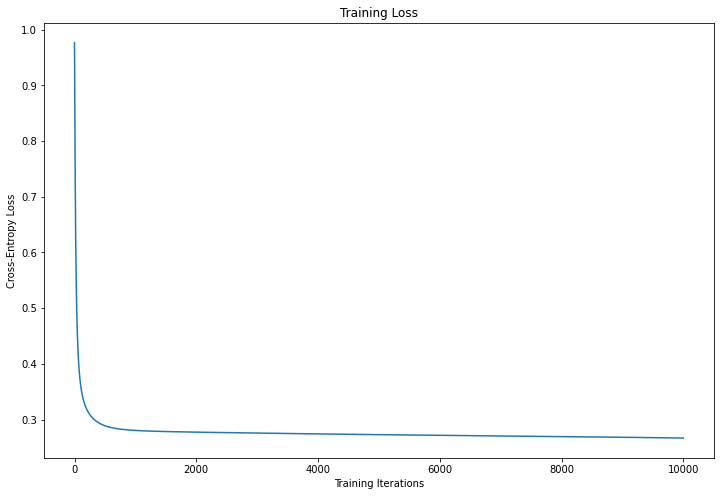

Training Accuracy: 0.88


In [ ]:
# train network and plot training loss
training_loss = nn.train(learning_rate = 0.1, log_loss=True)
plt.figure(figsize = (12, 8))
plt.plot(training_loss)
plt.title("Training Loss")
plt.xlabel("Training Iterations")
plt.ylabel("Cross-Entropy Loss")
plt.show()

print("Training Accuracy: %.2f" %nn.train_accuracy())

In [ ]:
# how does network perform on testing data
test_prediction = nn.predict(X_test)
np.sum(y_test.reshape(-1, 1) == test_prediction) / len(y_test)

0.872